# The Most Successful Franchise
The purpose of this jupyter notebook will be to determine who is the most consistently successful baseball franchise of all time. This, of course, is no small feat and will likely be hotly contested.
There are a very large number of ways that this can be approached that are all biased in one way or another.
* We could calculate the total number of wins over time that a team has gained, however this is biased to the teams that have been around for a long time.
* We could calculate the average number of wins / season, however this has the potential to bias towards teams that were only around for a few very hot seasons.
* We could also simply evaluate the number of championships a team has won and pick the highest.
* All of these methods have their merit, we will create a combined strategy of these to evaluate the most consistently successful franchise over time.
------------------


In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import scipy.stats

In [2]:
# Read in our data from the Teams.csv file
# This file contains all sorts of data about the games played and cumulative team stats for each year a team has played
filename = './Data/Teams.csv'
teams_df = pd.read_csv(filename)
teams_df.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,...,NaN,0.83,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,...,NaN,0.82,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,...,NaN,0.81,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,...,NaN,0.80,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,...,NaN,0.83,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


In [3]:
# Determine how many teams we have
len(teams_df['name'].unique())

139

In [4]:
# Create a cumulative sum of the wins of each team and place it in a column
teams_df['Cumulative Wins'] = teams_df.groupby(['name'])['W'].cumsum()

# Create a smaller dataframe with just the data that we want to use
small_df = teams_df[['name','Cumulative Wins','G','Ghome','yearID']]
teamnames = small_df['name'].unique()

# Sort and visualize the dataframe
small_df = small_df.sort_values(['name','yearID'])
small_df.head()

,name,Cumulative Wins,G,Ghome,yearID
124,Altoona Mountain City,6,25,NaN,1884
2237,Anaheim Angels,84,162,82.0,1997
2265,Anaheim Angels,169,162,81.0,1998
2295,Anaheim Angels,239,162,81.0,1999
2325,Anaheim Angels,321,162,81.0,2000


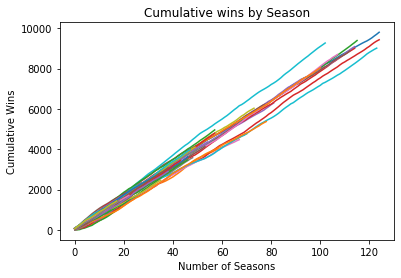

Team with the highest win rate: New York Yankees
They played for: 103 seasons
Total number of Games Won: 9266 games
Overall Win Rate: 89.96116504854369


In [5]:
# In this cell we loop through each team and plot their cumulative wins over the number of seasons they've played
count = 0
winrate = 0
teamwinner = ""
numseason = 0
numwins = 0
winratedictionary = {}


for team in teamnames:
    # Create a temporary dataframe with all of the data for a given team
    temp_df = small_df.loc[small_df['name'] == team,:]
    
    # Count the number of seasons they've been in the league
    seasons = temp_df['name'].count()
    
    # Grab the last value in the Cumulative Wins column and divide it by the number of seasons to get the average
    # number of wins / season, we will call this variable 'Win Rate' going forward
    calc = temp_df['Cumulative Wins'].iloc[-1] / seasons
    winratedictionary[team] = []
    winratedictionary[team].append(calc)
    
    # To avoid an incredible amount of clutter in the lower corner of our graph we filter out all the teams that were
    # Or have only been around for a short time.
    if seasons > 15:

        plt.plot(range(temp_df['name'].count()),temp_df['Cumulative Wins'])
        
        # Each loop determine if the current team is the new highest win rate
        # This is inside the loop to prevent 'Flash in the pan' teams from dominating our win rate values
        if calc > winrate:
            teamwinner = team
            winrate = calc
            numseason = seasons
            numwins = temp_df['Cumulative Wins'].iloc[-1]

plt.title('Cumulative wins by Season')
plt.xlabel('Number of Seasons')
plt.ylabel('Cumulative Wins')
plt.show()

# Print out the team with the highest win rate
# It actually is not the line that we see with a higher slope than the rest of them, this team has only been around
# for 11 seasons
print("Team with the highest win rate: " + teamwinner)
print('They played for: ' + str(numseason) + ' seasons')
print('Total number of Games Won: ' + str(numwins) + ' games')
print('Overall Win Rate: ' + str(winrate))


Simply looking at the plot above it is clear which team has been consistenly the best over their franchise history. This is the team with the highest overall win rate / season, that is the line with the highest slope on the above chart. It is clear taht there is only one team that is consistently above all of the rest, this is the New York Yankees. At this point we have a suspicion that they are the team we are looking for, but we will continue the analysis and see if we find anything else that is interesting.

In [6]:
# Take the winrates calculated above and place them into a separate dataframe
winrate_df = pd.DataFrame(winratedictionary)
winrate_df = winrate_df.transpose()

# Bump team name out of the index
winrate_df = winrate_df.reset_index()

# Rename the columns to match what we want them to be in the final dataframe
winrate_df = winrate_df.rename(columns = {'index':'name',0:'Win Rate'})

In [7]:
# Merge the winrate dataframe with our small dataframe
merged_df = pd.merge(small_df,winrate_df, left_on = 'name',right_on = 'name')
merged_df = merged_df.sort_values(['Win Rate','yearID'], ascending = False)

# Now we create a dataframe which focuses on the winrate so we can visualize our data more easily in the dataframe
mean_vals_df = merged_df.groupby('name').mean()

# Create a season count and add it to our dataframe
seasoncount = merged_df.groupby('name')['G'].count()
mean_vals_df['Seasons'] = seasoncount

# Sort the dataframe by Win Rate and add Win Fraction column
# Win rate will be biased towards teams playing more recently (with longer seasons) Win Fraction will control for this
mean_vals_df = mean_vals_df.sort_values('Win Rate', ascending = False)
mean_vals_df['Win Fraction'] = mean_vals_df['Win Rate'] / mean_vals_df['G']
mean_vals_df = mean_vals_df.reset_index()
mean_vals_df

,name,Cumulative Wins,G,Ghome,yearID,Win Rate,Seasons,Win Fraction
0,Los Angeles Angels of Anaheim,549.181818,162.000000,81.000000,2010.0,90.090909,11,0.556117
1,New York Yankees,4650.417476,156.679612,78.339806,1964.0,89.961165,103,0.574173
2,Tampa Bay Rays,408.125000,162.125000,81.375000,2011.5,88.375000,8,0.545104
3,Milwaukee Braves,624.076923,157.230769,78.692308,1959.0,88.153846,13,0.560665
4,Chicago Chi-Feds,87.000000,157.000000,NaN,1914.0,87.000000,1,0.554140
...,...,...,...,...,...,...,...,...
134,St. Paul White Caps,2.000000,9.000000,NaN,1884.0,2.000000,1,0.222222
135,Philadelphia Centennials,2.000000,14.000000,NaN,1875.0,2.000000,1,0.142857
136,Wilmington Quicksteps,2.000000,18.000000,NaN,1884.0,2.000000,1,0.111111
137,Keokuk Westerns,1.000000,13.000000,NaN,1875.0,1.000000,1,0.076923


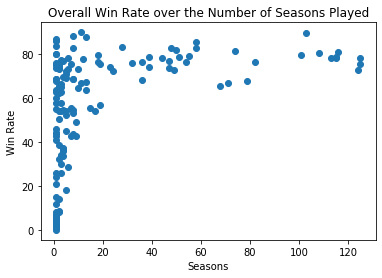

In [8]:
# Plot the wins/season for each team in our analysis over the number of season they've played
plt.scatter(mean_vals_df['Seasons'],mean_vals_df['Win Rate'], label = mean_vals_df['name'])
plt.xlabel('Seasons')
plt.ylabel('Win Rate')
plt.title('Overall Win Rate over the Number of Seasons Played')
plt.show()

This chart visualizes the relationship between number of seasons played and the win rate of a team. As expected there is an enormous grouping of teams hovering around the < 10 seasons mark. These teams, while potentially interesting for other reasons, may not be useful for our analysis. For our analysis we are in search of teams who are consistently good over a long timeframe.

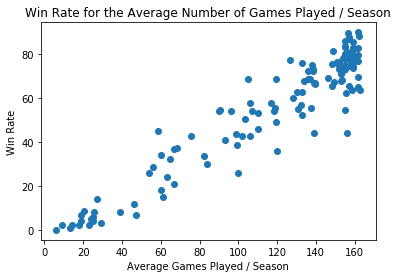

In [9]:
# 
plt.scatter(mean_vals_df['G'],mean_vals_df['Win Rate'])
plt.xlabel('Average Games Played / Season')
plt.ylabel('Win Rate')
plt.title('Win Rate for the Average Number of Games Played / Season')
plt.show()

This chart, once plotted, does seem quite obvious. The higher the average number of games played per season the higher your number of wins / season. There are a few teams that are outliers above and below the pack, but this chart is too coarse to give insight into whether they are true outliers.

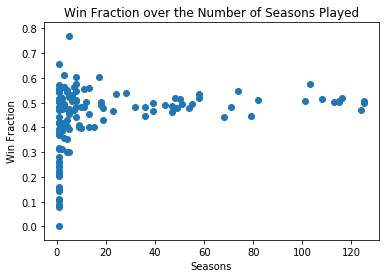

In [10]:
plt.scatter(mean_vals_df['Seasons'],mean_vals_df['Win Fraction'])
plt.xlabel('Seasons')
plt.ylabel('Win Fraction')
plt.title('Win Fraction over the Number of Seasons Played')
plt.show()

This chart also, depicts a trend that we would expect for teams playing a sport. Over time, especially once teams reach at least 20 seasons in the league they average around 0.500 every year. This intuitively makes sense as some years a team will put everything together and be able to win a lot of games together, and some years things won't fall into place anywhere near as smoothly.

In [11]:
seriesfile = './Data/SeriesPost.csv'
series_df = pd.read_csv(seriesfile)
print(series_df.shape)
series_df.head()

(307, 9)


,yearID,round,teamIDwinner,lgIDwinner,teamIDloser,lgIDloser,wins,losses,ties
0,1884,WS,PRO,NL,NYP,AA,3,0,0
1,1885,WS,CHC,NL,STL,AA,3,3,1
2,1886,WS,STL,AA,CHC,NL,4,2,0
3,1887,WS,DTN,NL,STL,AA,10,5,0
4,1888,WS,NYG,NL,STL,AA,6,4,0


In [12]:
series_df = series_df.loc[series_df['round'] == 'WS',:]
print(series_df.shape)
series_df.head()

(118, 9)


,yearID,round,teamIDwinner,lgIDwinner,teamIDloser,lgIDloser,wins,losses,ties
0,1884,WS,PRO,NL,NYP,AA,3,0,0
1,1885,WS,CHC,NL,STL,AA,3,3,1
2,1886,WS,STL,AA,CHC,NL,4,2,0
3,1887,WS,DTN,NL,STL,AA,10,5,0
4,1888,WS,NYG,NL,STL,AA,6,4,0


In [13]:
ws_winner = series_df['teamIDwinner']
series_df['teamIDwinner'].value_counts().head()

NYA    27
SLN    11
BOS     8
CIN     5
PIT     5
Name: teamIDwinner, dtype: int64

This cell really brings home our earlier conclusion from our win rate chart. It was clear from our first chart that the New York Yankees consistently put together winning seasons over their long history. That fact combined with this final chart places them in simply another level from the rest of the teams.
* The Yankees have won more championships than the next 3 teams combined.
* They have the second highest average win rate of any team in history. The only team with a higher rate is the Los Angeles Angels of Anaheim. However, they've only been around for ~1/10 of the time that the Yankees have been so it is too early to conclude their complete dominance of the sport. Especially since they have only achieved 1 World Series win in this time (and it was 18 years ago).

In [14]:
# Bring in the data for Hall of Fame Inductees
filename = './Data/HallOfFame.csv'
hof_df = pd.read_csv(filename)
hof_df = hof_df.rename(columns = {'yearid':'yearID'})
hof_df.head()

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN
...,...,...,...,...,...,...,...,...,...
4115,grudzma01,2016,BBWAA,440.0,330.0,0.0,N,Player,NaN
4116,ausmubr01,2016,BBWAA,440.0,330.0,0.0,N,Player,NaN
4117,hamptmi01,2016,BBWAA,440.0,330.0,0.0,N,Player,NaN
4118,castilu01,2016,BBWAA,440.0,330.0,0.0,N,Player,NaN


In [15]:
# Bring in the salary data
# This data is actually only used to map the players to their teams and not for their actual salaries
filename = './Data/Salaries.csv'
salary_df = pd.read_csv(filename)
salary_df

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000
...,...,...,...,...,...
25570,2015,WAS,NL,treinbl01,512800
25571,2015,WAS,NL,ugglada01,507500
25572,2015,WAS,NL,werthja01,21000000
25573,2015,WAS,NL,zimmejo02,16500000


In [16]:
# Merge the dataframes together
# Fillna with 'fluff' and then remove the columns with that value in the teamID column
hof_merged_df = pd.merge(hof_df,salary_df,on = ['playerID'], how = 'left')
hof_merged_df = hof_merged_df.fillna('fluff')
hof_merged_df = hof_merged_df.loc[hof_merged_df['teamID'] != 'fluff',:]
hof_merged_df.head()

,playerID,yearID_x,votedBy,ballots,needed,votes,inducted,category,needed_note,yearID_y,teamID,lgID,salary
3177,goltzda01,1989,BBWAA,447,336,0,N,Player,fluff,1985,LAN,NL,500000
3182,ziskri01,1989,BBWAA,447,336,0,N,Player,fluff,1985,SEA,AL,272500
3183,ziskri01,1989,BBWAA,447,336,0,N,Player,fluff,1986,SEA,AL,272500
3184,ziskri01,1989,BBWAA,447,336,0,N,Player,fluff,1987,SEA,AL,272500
3219,remyje01,1990,BBWAA,444,333,1,N,Player,fluff,1985,BOS,AL,483333


In [17]:
# This loop calculates the number of players inducted into the Hall of Fame for each team
hof_num = []
hof_team = []
# Loop through all teams represented in the HOF
for team in hof_merged_df['teamID'].unique():
    # Create a dataframe specifically for this team
    temp_df = hof_merged_df.loc[hof_merged_df['teamID'] == team,:]
    hof_team.append(team)
    # Find the number of unique players added to the HOF for this team
    hof_num.append(len(temp_df['playerID'].unique()))
# Create a dictionary of the player count that we've found    
hof_dict = {'Team':hof_team,'Number of Players':hof_num}
hof_final_df = pd.DataFrame(hof_dict).sort_values('Number of Players',ascending = False)
hof_final_df.head(10)


,Team,Number of Players
0,LAN,61
19,NYA,60
5,NYN,60
12,SDN,52
11,SLN,51
8,CLE,50
13,BAL,50
17,SFN,50
2,BOS,49
24,ATL,47


Note: This calculation does not account for the fact that a given player might have played for different teams during their career. This calculation in fact may grant this player to both teams. This artifically inflates the total number of Hall of Fame players in total, but since all teams are assisted equally it will not significantly bias our results.

In [18]:
# Due to inconsistencies in the way that teamID is called in different datasets the teamID is obtained here
# from the initial dataframe because this is the dataframe that our win rate came from
# If this step is not taken we lose almost all of the teams in our win rate calculation during the merge.
team_map_df = teams_df[['name','teamID']]
team_map_df

,name,teamID
0,Boston Red Stockings,BS1
1,Chicago White Stockings,CH1
2,Cleveland Forest Citys,CL1
3,Fort Wayne Kekiongas,FW1
4,New York Mutuals,NY2
...,...,...
2800,Los Angeles Dodgers,LAN
2801,San Francisco Giants,SFN
2802,Arizona Diamondbacks,ARI
2803,San Diego Padres,SDN


In [19]:
# Merge the dataframe to pair a team code to the win rate
mean_vals_df = pd.merge(mean_vals_df,team_map_df, left_on = 'name', right_on = 'name', how = 'left')
mean_vals_df

,name,Cumulative Wins,G,Ghome,yearID,Win Rate,Seasons,Win Fraction,teamID
0,Los Angeles Angels of Anaheim,549.181818,162.0,81.0,2010.0,90.090909,11,0.556117,LAA
1,Los Angeles Angels of Anaheim,549.181818,162.0,81.0,2010.0,90.090909,11,0.556117,LAA
2,Los Angeles Angels of Anaheim,549.181818,162.0,81.0,2010.0,90.090909,11,0.556117,LAA
3,Los Angeles Angels of Anaheim,549.181818,162.0,81.0,2010.0,90.090909,11,0.556117,LAA
4,Los Angeles Angels of Anaheim,549.181818,162.0,81.0,2010.0,90.090909,11,0.556117,LAA
...,...,...,...,...,...,...,...,...,...
2800,St. Paul White Caps,2.000000,9.0,NaN,1884.0,2.000000,1,0.222222,SPU
2801,Philadelphia Centennials,2.000000,14.0,NaN,1875.0,2.000000,1,0.142857,PH3
2802,Wilmington Quicksteps,2.000000,18.0,NaN,1884.0,2.000000,1,0.111111,WIL
2803,Keokuk Westerns,1.000000,13.0,NaN,1875.0,1.000000,1,0.076923,KEO


In [21]:
# Grab just the columns we need
mean_vals_df = mean_vals_df[['teamID','Win Rate']]
mean_vals_df

,teamID,Win Rate
0,LAA,90.090909
1,LAA,90.090909
2,LAA,90.090909
3,LAA,90.090909
4,LAA,90.090909
...,...,...
2800,SPU,2.000000
2801,PH3,2.000000
2802,WIL,2.000000
2803,KEO,1.000000


In [22]:
# Begin combining the columns we need from each of the different dataframes into a final summary
summary_df = hof_final_df
summary_df = pd.merge(summary_df, mean_vals_df, left_on = 'Team', right_on = 'teamID')
summary_df

,Team,Number of Players,teamID,Win Rate
0,LAN,61,LAN,85.465517
1,LAN,61,LAN,85.465517
2,LAN,61,LAN,85.465517
3,LAN,61,LAN,85.465517
4,LAN,61,LAN,85.465517
...,...,...,...,...
2109,LAA,4,LAA,90.090909
2110,LAA,4,LAA,77.000000
2111,LAA,4,LAA,77.000000
2112,LAA,4,LAA,77.000000


In [41]:
# Collect the series winner counts from above and rename the columns for subsequent merging into the summary dataframe
series_win_df = series_df['teamIDwinner'].value_counts().to_frame()
series_win_df = series_win_df.reset_index()
series_win_df = series_win_df.rename(columns = {'index': 'Team'})

In [24]:
# Merge the dataframes together to create our final summary dataframe
summary_df = pd.merge(summary_df, series_win_df, left_on = 'Team', right_on = 'Team')
summary_df 

,Team,Number of Players,teamID,Win Rate,teamIDwinner
0,LAN,61,LAN,85.465517,5
1,LAN,61,LAN,85.465517,5
2,LAN,61,LAN,85.465517,5
3,LAN,61,LAN,85.465517,5
4,LAN,61,LAN,85.465517,5
...,...,...,...,...,...
1736,ANA,18,ANA,83.000000,1
1737,ANA,18,ANA,83.000000,1
1738,ANA,18,ANA,83.000000,1
1739,ANA,18,ANA,83.000000,1


In [25]:
# Give our columns more meaningful names
summary_df = summary_df.rename(columns = {'Number of Players': 'Number of HoF Inductees','Win Rate': 'Average Wins/Season','teamIDwinner':'Number of WS Wins'})
summary_df

,Team,Number of HoF Inductees,teamID,Average Wins/Season,Number of WS Wins
0,LAN,61,LAN,85.465517,5
1,LAN,61,LAN,85.465517,5
2,LAN,61,LAN,85.465517,5
3,LAN,61,LAN,85.465517,5
4,LAN,61,LAN,85.465517,5
...,...,...,...,...,...
1736,ANA,18,ANA,83.000000,1
1737,ANA,18,ANA,83.000000,1
1738,ANA,18,ANA,83.000000,1
1739,ANA,18,ANA,83.000000,1


In [42]:
# Remove the extra teamID column
summary_df = summary_df[['Team','Number of HoF Inductees','Average Wins/Season','Number of WS Wins']]
summary_df

,Team,Number of HoF Inductees,Average Wins/Season,Number of WS Wins
0,LAN,1.000000,0.950027,0.185185
1,LAN,1.000000,0.950027,0.185185
2,LAN,1.000000,0.950027,0.185185
3,LAN,1.000000,0.950027,0.185185
4,LAN,1.000000,0.950027,0.185185
...,...,...,...,...
1736,ANA,0.295082,0.922620,0.037037
1737,ANA,0.295082,0.922620,0.037037
1738,ANA,0.295082,0.922620,0.037037
1739,ANA,0.295082,0.922620,0.037037


In [62]:
# In this cell we normalize our data. If we do not normalize any calculation that we perform will be heavily skewed
# by the larger values in win rate. Given that many of the values in taht column were of similar magnitude it would
# unnecessarily complicate our analysis.
# We then create a weight for each of our three data points and graph the final score.
# Number of Hall of Fame Inductees is weighted 0.2
# Average wins / Season is weighted 0.3
# Number of World Series wins is wieghted 0.5 - This value was rated more highly than the others simply because it is
# the best indication of overall team success. A team could have a phenomenal average win rate, but if they can't 
# finish the job and win the world series, how much does that really matter?
summary_df_norm = summary_df
summary_df_norm['Number of HoF Inductees'] = summary_df_norm['Number of HoF Inductees'] / summary_df_norm['Number of HoF Inductees'].max()
summary_df_norm['Average Wins/Season'] = summary_df_norm['Average Wins/Season']/summary_df_norm['Average Wins/Season'].max()
summary_df_norm['Number of WS Wins'] = summary_df_norm['Number of WS Wins'] / summary_df_norm['Number of WS Wins'].max()
summary_df_norm = summary_df_norm.groupby('Team').mean()
summary_df_norm['Score'] = summary_df_norm['Number of HoF Inductees'] * 0.2 + summary_df_norm['Average Wins/Season'] * 0.3 + summary_df_norm['Number of WS Wins'] * 0.5
summary_df_norm = summary_df_norm.reset_index()
summary_df_norm.head()

,Team,Number of HoF Inductees,Average Wins/Season,Number of WS Wins,Score
0,ANA,0.295082,0.922620,0.037037,0.354321
1,ARI,0.393443,0.885567,0.037037,0.362877
2,ATL,0.770492,0.912838,0.037037,0.446468
3,BAL,0.819672,0.852943,0.111111,0.475373
4,BOS,0.803279,0.891592,0.296296,0.576282


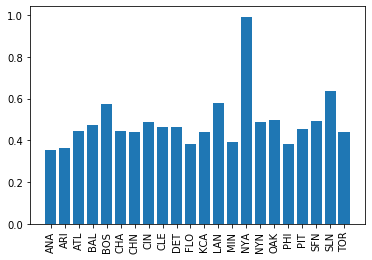

In [40]:
# Graph the scores that we calculated earlier, due to our weighting and normalizing the maximum possible score is 1.0
plt.bar(summary_df_norm['Team'],summary_df_norm['Score'])
plt.xticks(rotation = 90)
plt.show()

In [61]:
# Calculate the quantiles and the IQR
# From this we then observe any outliers
lowerquantile = summary_df_norm['Score'].quantile([0.25]).to_frame()
lowerquantile = lowerquantile['Score'].iloc[0]
upperquantile = summary_df_norm['Score'].quantile([0.75]).to_frame()
upperquantile = upperquantile['Score'].iloc[0]
iqr =  upperquantile - lowerquantile
lower_bound = lowerquantile - 1.5*iqr
upper_bound = upperquantile + 1.5*iqr
outliers = summary_df_norm.loc[(summary_df_norm['Score'] < lower_bound) | (summary_df_norm['Score'] > upper_bound),:]
outliers

,Team,Number of HoF Inductees,Average Wins/Season,Number of WS Wins,Score
0,ANA,0.295082,0.922620,0.037037,0.354321
12,LAN,1.000000,0.950027,0.185185,0.577601
14,NYA,0.983607,0.983709,1.000000,0.991834
20,SLN,0.836066,0.890578,0.407407,0.638090


From the preceding analysis we find 4 outliers. 3 teams are outliers above the IQR and one is below. It is clear, both from the graph and this table that there is one team that exists head and shoulders above the rest of the teams. From this calculation we are left with the conclusion that the Most Successful Franchise of all time is: The New York Yankees.